<a href="https://colab.research.google.com/github/fluxtransport/HelioLectures/blob/commit_from_colab/notebooks/sunspot_lecture_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sunspot Models
## Author: Mark Cheung (github @fluxtransport)

### In this notebook, we
### 1. develop a axisymmetric model of the magnetic field structure of a sunspot, and 
### 2. Inspect spatial distribution of MHD quantities.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy.interpolate

import sympy as sp
from sympy.utilities.lambdify import lambdify
from sympy import init_printing
init_printing(use_unicode=True)


In [ ]:
# Curl operator in cylindrical coordinates
def curl(V, x):
    from sympy import diff
    curlV = (diff(V[2], x[1])/x[0]  - diff(V[1],x[2]),
             diff(V[0], x[2]) - diff(V[2], x[0]),
             (diff(x[0]*V[1], x[0]) - diff(V[0], x[1]))/x[0]
            )
    return curlV

def AxB(A, B):
    return ((A[1]*B[2]-A[2]*B[1]),
            (A[2]*B[0]-A[0]*B[2]),
            (A[0]*B[1]-A[1]*B[0]))

## 1. Axisymmetric model of sunspot 
#### Schlüter & Temesvàry ([1958]( https://articles.adsabs.harvard.edu/pdf/1958IAUS....6..263S )) sought to obtain a magnetohydrostatic equilibrium solution to sunspot structure.

#### They made the following assumptions.

A1. Cylindrical symmetry ($r$ is radial distance from axis of symmetry, $\theta$ is azimuth, $z$ is depth): $j_z(r=0) = B_r(r=0)=0$. 

A2. Time-independent solution: $\partial / \partial t = 0$

A3. $\vec{B}, $and derivatives$ \to 0$ as $r \to \infty$ and $z \to -\infty$

B1. Plasma velocity inside spot $v=0$

B2. $B_\theta = 0$ everywhere, so that magnetic field lines lie on $r-z$ planes at fixed $\theta$.

B3. Assume relative cross-sectional profile is everywhere geometrically similar. 

#### The following example is inspired by, but does not exactly follow their derivation. 

In [ ]:
# Define sympy symbols and functions
r, theta, z, zeta = sp.symbols('r theta z zeta')
r1 = sp.symbols('r1') # need a dummy variable to calculate the flux function
R = sp.Function('R')(z)


# Define height profiles Hp and zeta change everything. 
H = 2-z/3 #0.5-z/2. #sp.Piecewise( (2+(-z), z<=0), (2, z>0)) # Mm
#H = sp.Piecewise( (2+(-z)/2, z<=0), (1, z>0))
zeta = sp.exp(-z/H) #sp.Piecewise( (sp.exp(-z/Hp),z<=0), (1-z/Hp, z>0))

B0 = 4000.*(zeta*zeta) # Bz component at axis r=0, in Gauss
R0 = 8 # effective radius of flux tube at z=0, in Mm
R = R0/(zeta) # Effective radius of flux tube as a function of zeta (and of depth z)

# Magnetic field profiles
Bz = B0*sp.exp(-r*r/(R*R)) # Vertical component, + means downward
Bt = 0 #Azimuthal component, zero
# Assuming div B=0, we obtain the following solution for Br
Br = sp.integrate(-r*sp.diff(Bz, z), r)/r # This has the right boundary condition such that Br=0 at r=0.
# Tuple operations
B = (Br, Bt, Bz)
curlB = curl(B , (r,theta,z))
# Lorentz Force
L = AxB(curlB, B)
L = (L[0]/(4*sp.pi),L[1]/(4*sp.pi),L[2]/(4*sp.pi))

# The flux function F(r) is the vertical magnetic flux contained within r'\in[0,r]
flux = sp.integrate(Bz*r, (r,0,r1))*2*sp.pi

#Lambdify to create functions that can be used to evalute on a grid (used later)
Bz_func = lambdify((r,z),Bz,"numpy")
Br_func = lambdify((r,z),Br,"numpy")
flux_func = lambdify((r1,z),flux,"numpy")
Lr_func = lambdify((r,z), L[0],"numpy")
Lz_func = lambdify((r,z), L[2],"numpy")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.40000000000000036


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


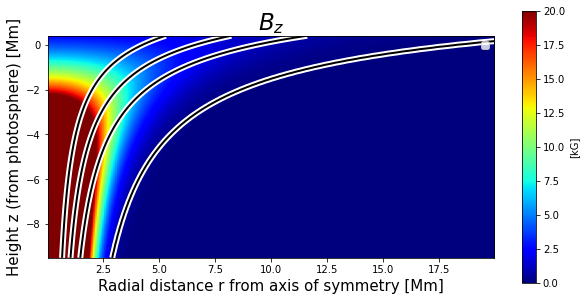

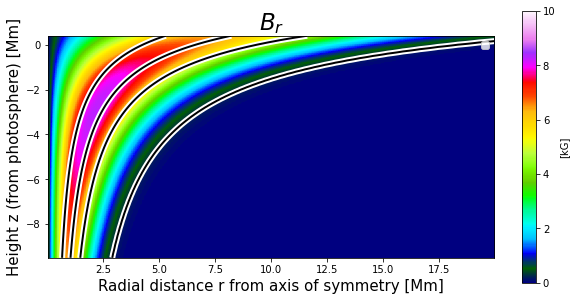

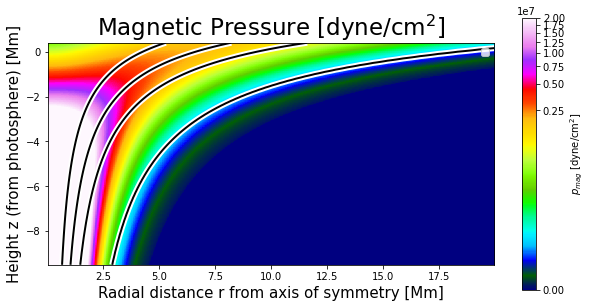

In [ ]:
# Evaluate Bz on a Cartesian grid in r-z
Nr = 200
Nz = 100
radius = ((np.arange(Nr)+0.5)*0.1) # Mm
height= (np.arange(Nz)*0.1 - 9.5) # Mm
print(height.max())
height, radius = np.meshgrid(height, radius)

Bz_array = Bz_func(radius, height)
Br_array = Br_func(radius, height)
flux_array = flux_func(radius, height)
Lz_array = Lz_func(radius, height) / 1e8 # Need this factor to convert derivatives /Mm to /cm
Lr_array = Lr_func(radius, height) / 1e8 #N eed this factor to convert derivatives /Mm to /cm

# Magnetic pressure
pB_array = (Bz_array**2+Br_array**2)/8./np.pi

# Plot cross-sectional profiles
extent=(radius.min(),radius.max(), height.min(), height.max())
# Flux surfaces for contours
flux_surfaces = np.linspace(2e5,8e5,num=4) # in G Mm^2 = 10^16 Mx

plt.figure(figsize=(10,5))
plt.title("$B_z$", fontsize=23)
plt.imshow(Bz_array.T/1e3, cmap='jet', extent=extent, vmin=0,vmax=20, origin='lower')
plt.colorbar(label='[kG]')

plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='white', 
            extent=extent, linewidths=6,alpha=1)
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='k', 
            extent=extent, linewidths=2,alpha=1.)

plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.legend()

plt.figure(figsize=(10,5))
plt.title("$B_r$", fontsize=23)
plt.imshow(Br_array.T/1e3, cmap='gist_ncar', extent=extent, vmin=0, vmax=10, origin='lower')
plt.colorbar(label='[kG]')
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='white', 
            extent=extent, linewidths=6,alpha=1)
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='k', 
            extent=extent, linewidths=2,alpha=1.)

plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.legend()

plt.figure(figsize=(10,5))
plt.title("Magnetic Pressure [dyne/cm$^2$]", fontsize=23)
plt.imshow(pB_array.T, cmap='gist_ncar', extent=extent, 
           origin='lower', norm=colors.PowerNorm(0.2,vmin=1e-2,vmax=2e7))
plt.colorbar(label='$p_{mag}$ [dyne/cm$^2$]')
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='white', 
            extent=extent, linewidths=6,alpha=1)
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='k', 
            extent=extent, linewidths=2,alpha=1.)

plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.legend()

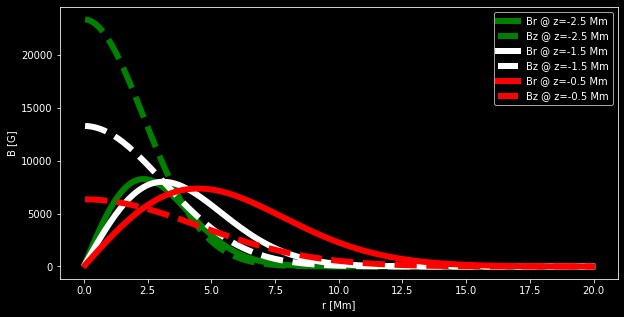

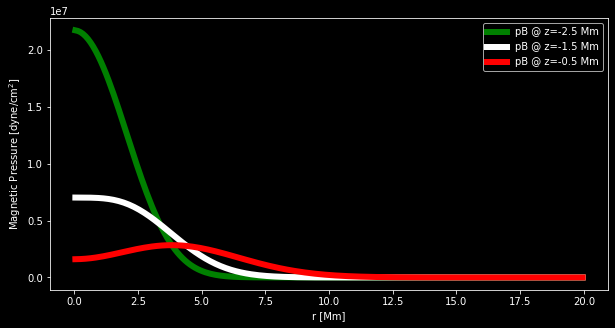

In [ ]:
with plt.style.context('dark_background'):
    cs= ['green','white','red','gold']
    plt.figure(figsize=(10,5))
    for i,d in enumerate([-30,-20,-10]):
        plt.plot(radius[:,d],Br_array[:,d], label='Br @ z={0:.1f} Mm'.format(height[0,d]), color=cs[i], linewidth=6)
        plt.plot(radius[:,d],Bz_array[:,d], "--", label='Bz @ z={0:.1f} Mm'.format(height[0,d]), color=cs[i], linewidth=6)
    plt.xlabel('r [Mm]')
    plt.ylabel('B [G]')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    for i,d in enumerate([-30,-20,-10]):
        plt.plot(radius[:,d],pB_array[:,d], label='pB @ z={0:.1f} Mm'.format(height[0,d]), color=cs[i], linewidth=6)
    plt.xlabel('r [Mm]')
    plt.ylabel('Magnetic Pressure [dyne/cm$^2$]')
    plt.legend()
    plt.show()

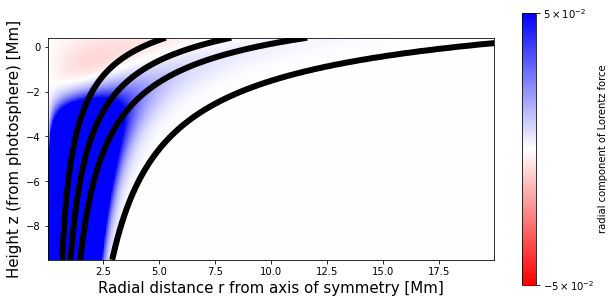

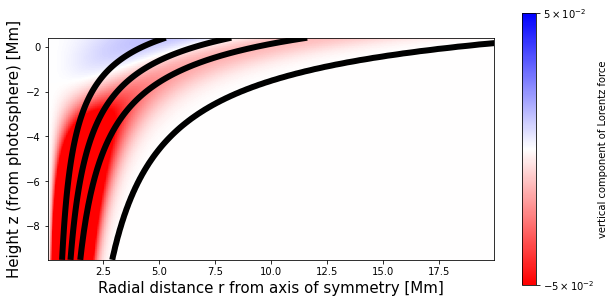

In [ ]:
curlB_theta = sp.diff(Br,z)-sp.diff(Bz,r)
plt.figure(figsize=(10,5))

plt.imshow(Lr_array.T, cmap='bwr_r', norm=colors.SymLogNorm(1e4,vmin=-5e-2,vmax=5e-2), extent=extent, origin='lower')
plt.colorbar(label='radial component of Lorentz force')
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='k', 
            extent=extent, linewidths=6,alpha=1)
plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(Lz_array.T, cmap='bwr_r', norm=colors.SymLogNorm(1e4,vmin=-5e-2,vmax=5e-2), extent=extent, origin='lower')
plt.colorbar(label='vertical component of Lorentz force')
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='k', 
            extent=extent, linewidths=6,alpha=1)
plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)
plt.show()

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

def bokeh_image(array, radius, height, title=""):
    x = radius
    y = height

    p = figure(tooltips=[("r", "$x"), ("z", "$y"), ("value", "@image")], 
               x_range=(radius.min(),radius.max()),
               y_range=(height.min(), height.max()), 
               plot_height=400, plot_width=1000,
               title=title)

    # must give a vector of image data for image parameter
    p.image(image=[array.T], x=radius.min(), y=height.min(), dw=radius.max()-radius.min(), 
            dh=(height.max()-height.min()), palette='Inferno9', level="image")
    p.xaxis.axis_label = 'Radius [Mm]'
    p.yaxis.axis_label = 'Height [Mm]'
    p.grid.grid_line_width = 0.5
    show(p)
    return p

bokeh_image(Lz_array, radius[:,0], height[0,:], title="z-component of Lorentz force")

Loading BokehJS ...

Figure(id='1108', ...)

### Load a convection zone model to get a solar-like stratification 
### The following is from [Kiefer et al.](https://ui.adsabs.harvard.edu/abs/2000A%26A...355..381K/abstract)

<AxesSubplot:xlabel='z'>

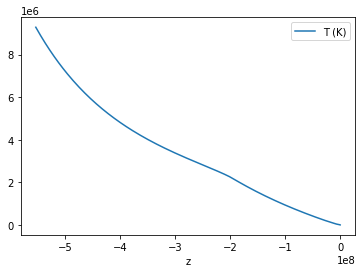

In [ ]:
import pandas as pd
df = pd.read_csv('http://sun.stanford.edu/~cheung/data/Kiefer_modell8b.csv')
df['T (K)'] = np.exp(df['LNT']) # natural log of T
df['z'] =  df['R'] - 6.957000e+08 # Convert radius to height from photosphhere, in m
df.plot(x='z', y='T (K)')

In [ ]:
df

,Unnamed: 0,LNPTOT,R,MR,LNT,LNTAU,LNPTH,LNPGAS,LNPRAD,LNRHO,...,NABLA_RAD,NABLA,NABLA_PRIME,DT,V,F_C,S,LNPTURB,T (K),z
0,0,9.177833,6.959800e+08,1.989100e+30,8.661674,-0.405465,9.177833,9.177804,-1.269655,-8.243478,...,0.275560,0.275560,0.0,0.000000,0.000000,0.000000,0.0,0.000000,5.777200e+03,2.800000e+05
1,1,9.231477,6.959727e+08,1.989100e+30,8.677311,-0.284056,9.231477,9.231448,-1.207108,-8.205531,...,0.308134,0.308134,0.0,0.000000,0.000000,0.000000,0.0,0.000000,5.868246e+03,2.727374e+05
2,2,9.285122,6.959654e+08,1.989100e+30,8.694909,-0.155208,9.285122,9.285092,-1.136716,-8.169556,...,0.349849,0.349849,0.0,0.000000,0.000000,0.000000,0.0,0.000000,5.972431e+03,2.653531e+05
3,3,9.338766,6.959578e+08,1.989100e+30,8.715040,-0.016198,9.338766,9.338735,-1.056192,-8.136131,...,0.403621,0.403621,0.0,0.143667,19.642064,13.703553,0.0,-2.180784,6.093879e+03,2.578281e+05
4,4,9.392410,6.959501e+08,1.989100e+30,8.738510,0.136612,9.392410,9.392378,-0.962315,-8.106072,...,0.475866,0.475841,0.0,5.517160,121.769266,3392.736006,0.0,1.498184,6.238590e+03,2.501373e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,35.731778,1.538773e+08,7.939971e+29,15.987574,27.441049,35.731778,35.731324,28.033943,10.240257,...,0.254583,0.254583,0.0,0.000000,0.000000,0.000000,0.0,12.368677,8.776376e+06,-5.418227e+08
496,496,35.785423,1.510452e+08,7.703632e+29,16.001321,27.464070,35.785423,35.784968,28.088930,10.279931,...,0.257936,0.257936,0.0,0.000000,0.000000,0.000000,0.0,12.368677,8.897855e+06,-5.446548e+08
497,497,35.839067,1.481926e+08,7.465109e+29,16.015248,27.487269,35.839067,35.838612,28.144641,10.319422,...,0.261332,0.261332,0.0,0.000000,0.000000,0.000000,0.0,12.368677,9.022648e+06,-5.475074e+08
498,498,35.892711,1.453179e+08,7.224565e+29,16.029360,27.510637,35.892711,35.892255,28.201086,10.358727,...,0.264786,0.264786,0.0,0.000000,0.000000,0.000000,0.0,12.368677,9.150872e+06,-5.503821e+08


In [ ]:
# Interpolate the Mixing Length Convection Zone model to get stratifcation of gas pressure 
p_bg= np.exp(scipy.interpolate.interp1d(df['z'][::-1], df['LNPGAS'][::-1], kind='linear', fill_value='extrapolate')(height[0,:]*1e6), )
#the 1e6 factor after height[0,:] converts Mm to m
p_bg*= 10 # convert Pascals to dyne/cm^2
p_bg = np.clip(p_bg,3e6,None) # clip the extrapolated gas pressure in the photsphere to a minimum of 3e6 dyne/cm^2
# Make 2D plane parallel stratification with the interpolated atmosphere
p_bg = np.ones(shape=(Nr,1))@p_bg.reshape((1,Nz))

# Integrate the radial component of the Lorentz force, this will give the pressure deficit in the tube
pres=sp.integrate(L[0],(r,0,r1))
pres_array = lambdify((r1,z),pres, "numpy")(radius,height)
for i in range(Nz):
    pres_array[:,i] -= pres_array[-1,i]
# The pressure in the domain is the plane-parallel atmosphere, minus the presure deficit
pres_array = p_bg+pres_array


#### Let us inspect the distribution of the plasma $\beta$.

 \begin{eqnarray} 
 \beta & = & p_G/p_M \\
 & = & 8\pi p/B^2 \\
 & = & (2p/\varrho) (B^2/4\pi\varrho)^{-1} \\
 & \approx & (c_s/v_A)^2 & 
 \end{eqnarray}
 
#### where $c_s = \sqrt{\gamma p \varrho^{-1}}$ is the adiabatic sound speed, and $v_A = B(4\pi \varrho)^{-1/2}$ is the Alfvén speed.
 
 

Text(0, 0.5, 'Height z (from photosphere) [Mm]')

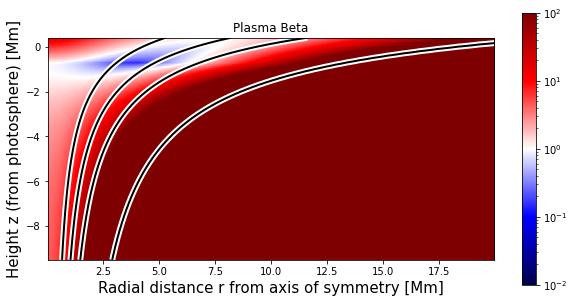

In [ ]:
# Compute plasma beta 8\pip / B^2
beta=(pres_array)/pB_array
plt.figure(figsize=(10,5))
plt.title("Plasma Beta")
plt.imshow(beta.T,origin='lower', norm=colors.LogNorm(vmin=1e-2,vmax=1e2), extent=extent, cmap='seismic')
plt.colorbar()
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='white', 
            extent=extent, linewidths=6,alpha=1)
plt.contour(radius, height,flux_array, levels=flux_surfaces,colors='k', 
            extent=extent, linewidths=2,alpha=1.)
plt.xlabel('Radial distance r from axis of symmetry [Mm]', fontsize=15)
plt.ylabel('Height z (from photosphere) [Mm]', fontsize=15)


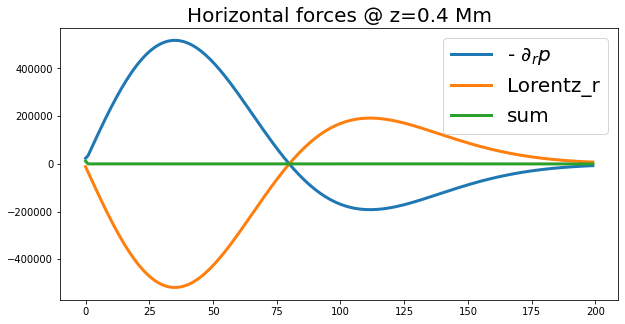

In [ ]:
# Check lateral force balance
k = -1 # change this to plot at different depths
pgrad_force= -np.gradient(pres_array,axis=0)[:,k]/(radius[1,0]-radius[0,0])
plt.figure(figsize=(10,5))
plt.title('Horizontal forces @ z={0:.1f} Mm'.format(height[0,k]), fontsize=20)
plt.plot(pgrad_force, label="- $\partial_r p$", linewidth=3)
plt.plot(Lr_func(radius,height)[:,k], label="Lorentz_r", linewidth=3)
plt.plot(Lr_func(radius,height)[:,k]+pgrad_force,label="sum", linewidth=3)
plt.legend(fontsize=20)
plt.show()


## Now we have an azisymmetric model with lateral force balance. However, it is not in mechanical balance in the vertical direction!

### Let us review whether the model assumptions are reasonable. Consider the momentum equation:

### $$\frac{\partial \varrho \mathbf{V}}{\partial t} + \nabla \cdot \mathbf{T} - \varrho \mathbf{g}= 0$$

### where $\varrho$ is the density, $\mathbf{V}$ the plasma velocity, $\vec{g}$ the gravitational acceleration, and the stress tensor $\mathbf{T}$ is

### $$\mathbf{T} = \varrho \mathbf{V}\mathbf{V} + \left( p_g + \frac{B^2}{8\pi} \right)\mathbf{I} - \frac{1}{4\pi}\mathbf{B}\mathbf{B},$$

### where $p_{g}$ the gas pressure. 

### Assumption A2 (time-independence): $\to  \nabla \cdot \mathbf{T} - \varrho \mathbf{g}= 0$

### Assumption B1 (no plasma flows): $\to  \nabla \cdot \left[ \left( p_g + \frac{B^2}{8\pi} \right)\mathbf{I} - \frac{1}{4\pi}\mathbf{B}\mathbf{B} \right] - \varrho \mathbf{g}= 0$
